<a href="https://colab.research.google.com/github/seonekr/humascot-taca/blob/main/%5Bhandson%5DLlama_3_1_8b_finetuning_kr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 만든이 [코난쌤TV](https://www.youtube.com/@conanssam)
- <a href="https://www.youtube.com/@conanssam">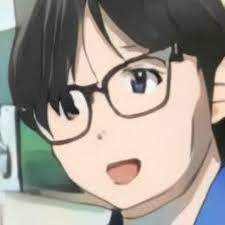</a>

- unsloth에서 예제로 제공하는 [llama-3.1 8b-finetune](https://github.com/unslothai/unsloth) 을 참고하여 수정,번역하였습니다
- 한국어 데이터셋을 이용해서 모델을 finetune합니다.
- 코랩 무료(T4)에서 돌아가는것을 확인 했습니다.

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

* 우리는 Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes 등을 지원합니다.
* 우리는 16비트 LoRA 또는 4비트 QLoRA를 지원합니다. 둘 다 2배 빠릅니다.
* `max_seq_length`는 무엇이든 설정할 수 있으며, [kaiokendev의](https://kaiokendev.github.io/til) 방법을 통해 자동 RoPE 스케일링을 수행합니다.
* [**NEW**] 우리는 Gemma-2 9b / 27b를 **2배 빠르게** 만듭니다! 우리의 [Gemma-2 9b 노트북](https://colab.research.google.com/drive/1vIrqH5uYDQwsJ4-OO3DErvuv4pBgVwk4?usp=sharing)을 참조하세요.
* [**NEW**] Ollama로 파인튜닝하고 자동으로 내보내려면 우리의 [Ollama 노트북](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)을 사용해보세요.
* [**NEW**] 우리는 Mistral NeMo 12B를 2배 빠르게 만들고 12GB 이하의 VRAM에 맞춥니다! [Mistral NeMo 노트북](https://colab.research.google.com/drive/17d3U-CAIwzmbDRqbZ9NnpHxCkmXB6LZ0?usp=sharing)을 참조하세요.


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",          # Phi-3 2x faster!d
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

이제 LoRA 어댑터를 추가하여 전체 매개변수의 1~10%만 업데이트하면 됩니다!
## LoRA(Low-Rank Adaptation)
<img src="https://blog.kakaocdn.net/dn/5hM9Y/btsEf71AKDs/PHhKnMg6mQFSCE1BsnSat1/img.png">


- [Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

## 주요 개념 설명:

1. PEFT (Parameter-Efficient Fine-Tuning):
   - 대규모 언어 모델의 효율적인 미세 조정 기법
   - 전체 모델 대신 일부 파라미터만 조정하여 학습 효율성 향상

2. LoRA (Low-Rank Adaptation):
   - PEFT의 한 방법으로, 적은 수의 훈련 가능한 파라미터를 추가하여 모델 미세 조정
   - 'r' 파라미터로 LoRA의 랭크 지정

3. Gradient Checkpointing:
   - 긴 시퀀스 처리 시 메모리 사용을 최적화하는 기법
   - "unsloth" 옵션으로 더 나은 메모리 효율성 제공

4. RS-LoRA (Rank-Stabilized LoRA):
   - LoRA의 변형으로, 학습 안정성 개선

5. LoftQ:
   - 모델 압축을 위한 양자화 기법

6. FastLanguageModel:
   - 최적화된 언어 모델 처리를 위한 사용자 정의 클래스
   - get_peft_model 메소드로 PEFT 설정 적용


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # 0보다 큰 숫자를 선택하세요! 권장값: 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # 어떤 값이든 지원하지만, 0이 최적화되어 있습니다
    bias = "none",    # 어떤 값이든 지원하지만, "none"이 최적화되어 있습니다
    # [새로운 기능] "unsloth"는 30% 더 적은 VRAM을 사용하며, 2배 더 큰 배치 크기를 지원합니다!
    use_gradient_checkpointing = "unsloth", # 매우 긴 컨텍스트의 경우 True 또는 "unsloth" 사용
    random_state = 3407,
    use_rslora = False,  # 순위 안정화 LoRA를 지원합니다
    loftq_config = None, # 그리고 LoftQ도 지원합니다
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### 데이터 준비
이제 한국어 데이터셋으로 [korean_safe_conversation](https://huggingface.co/datasets/jojo0217/korean_safe_conversation)을 사용합니다.

**[참고]** 사용자의 입력을 무시하고 완료된 부분만 학습하려면 TRL의 문서를 [여기](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only)에서 읽어보세요.

**[참고]** 토큰화된 출력에 **EOS_TOKEN**을 추가하는 것을 잊지 마세요!! 그렇지 않으면 무한 생성이 발생할 수 있습니다!

ShareGPT 데이터셋에 `llama-3` 템플릿을 사용하려면 우리의 대화형 [노트북](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing)을 참조하세요.

소설 작성과 같은 텍스트 완성을 위해서는 이 [노트북](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)을 시도해보세요.


## 주요 개념 설명:

1. 프롬프트 엔지니어링:
   - 언어 모델에 특정 형식의 입력을 제공하여 원하는 출력을 유도하는 기법
   - 여기서는 Alpaca 형식의 프롬프트를 사용하여 지시사항, 입력, 출력을 구조화

2. 데이터셋 전처리:
   - 원시 데이터를 모델 학습에 적합한 형태로 변환하는 과정
   - formatting_prompts_func 함수를 사용하여 데이터셋의 각 예제를 프롬프트 형식으로 변환

3. Hugging Face Datasets:
   - 다양한 NLP 데이터셋을 쉽게 로드하고 처리할 수 있게 해주는 라이브러리
   - load_dataset 함수로 데이터셋을 로드하고, map 메소드로 전처리 함수를 적용

4. EOS 토큰:
   - End of Sequence 토큰으로, 텍스트 생성의 종료 시점을 모델에게 알려주는 역할
   - 무한 생성을 방지하기 위해 각 예제의 끝에 추가

5. 배치 처리:
   - map 함수의 batched=True 옵션을 사용하여 데이터를 배치 단위로 처리
   - 대량의 데이터를 효율적으로 처리할 수 있게 함

In [ ]:
alpaca_prompt = """아래에는 작업을 설명하는 지시 사항과 추가적인 컨텍스트를 제공하는 입력이 있습니다. 요청을 적절하게 완료하는 응답을 작성하세요.

### instruction:
{}

### input:
{}

### output:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
# 한국어 데이터셋 로드
dataset = load_dataset("jojo0217/korean_safe_conversation", split = "train")
# 데이터셋에 프롬프트 포맷팅 함수 적용
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/26979 [00:00<?, ? examples/s]

Map:   0%|          | 0/26979 [00:00<?, ? examples/s]

<a name="Train"></a>
### 모델 학습
이제 Huggingface TRL의 `SFTTrainer`를 사용해 봅시다! 자세한 문서는 여기에서 확인하세요: [TRL SFT 문서](https://huggingface.co/docs/trl/sft_trainer).

속도를 높이기 위해 60단계로 설정했지만, 전체 실행을 위해 `num_train_epochs=1`로 설정하고 `max_steps=None`을 끌 수 있습니다.

우리는 또한 TRL의 `DPOTrainer`를 지원합니다!


## 코드에 사용된 개념 설명
1. SFT Trainer (Supervised Fine-Tuning Trainer):
   - 지도 학습 기반의 미세 조정을 위한 훈련기
   - 사전 훈련된 모델을 특정 태스크에 맞게 조정하는 데 사용
   - 허깅페이스에서 제공하는 TRL 라이브러리 사용

2. TrainingArguments:
   - 훈련 과정을 세밀하게 제어하기 위한 다양한 하이퍼파라미터 설정
   - 배치 크기, 학습률, 최적화 방법 등을 지정

3. 그래디언트 누적 (Gradient Accumulation):
   - 여러 배치의 그래디언트를 누적한 후 한 번에 가중치 업데이트
   - 메모리 효율성을 높이고 더 큰 배치 효과를 얻을 수 있음

4. 학습률 스케줄링 (Learning Rate Scheduling):
   - 학습 과정에서 학습률을 동적으로 조절하는 기법
   - 여기서는 선형 스케줄링을 사용

5. 혼합 정밀도 훈련 (Mixed Precision Training):
   - fp16 또는 bfloat16을 사용하여 메모리 사용량 감소 및 연산 속도 향상
   - 하드웨어 지원 여부에 따라 자동으로 선택

6. 옵티마이저 (Optimizer):
   - adamw_8bit: 메모리 효율적인 Adam의 변형
   - 가중치 감소(weight decay)를 통한 정규화 적용

7. 시드 설정 (Seed):
   - 실험의 재현성을 보장하기 위해 난수 생성 시드 고정

8. 로깅 (Logging):
   - 훈련 과정을 모니터링하기 위한 로그 기록 주기 설정


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # 짧은 시퀀스의 경우 학습 속도를 5배 빠르게 할 수 있습니다.
    args = TrainingArguments(
        per_device_train_batch_size = 2, # 각 장치별 배치 크기를 2로 설정합니다.
        gradient_accumulation_steps = 4, # 그래디언트 누적 단계를 4로 설정합니다.
        warmup_steps = 5, # 워밍업 단계를 5로 설정합니다.
        # num_train_epochs = 1, # 전체 학습을 위해 이 값을 1로 설정합니다.
        max_steps = 60, # 최대 단계를 60으로 설정합니다.
        learning_rate = 2e-4, # 학습률을 2e-4로 설정합니다.
        fp16 = not is_bfloat16_supported(), # bfloat16 지원 여부에 따라 fp16을 설정합니다.
        bf16 = is_bfloat16_supported(), # bfloat16 지원 여부에 따라 bf16을 설정합니다.
        logging_steps = 1, # 로그 기록 단계를 1로 설정합니다.
        optim = "adamw_8bit", # 옵티마이저를 adamw_8bit로 설정합니다.
        weight_decay = 0.01, # 가중치 감소를 0.01로 설정합니다.
        lr_scheduler_type = "linear", # 학습률 스케줄러 유형을 linear로 설정합니다.
        seed = 3407, # 시드를 3407로 설정합니다.
        output_dir = "outputs", # 출력 디렉토리를 "outputs"로 설정합니다.
    ),
)


Map (num_proc=2):   0%|          | 0/26979 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title 현재 메모리 상태 표시
# torch.cuda.get_device_properties(0)을 사용하여 첫 번째 GPU의 속성을 가져옵니다.
gpu_stats = torch.cuda.get_device_properties(0)

# torch.cuda.max_memory_reserved()를 사용하여 현재 예약된 최대 GPU 메모리를 가져오고,
# 이를 기가바이트(GB) 단위로 변환하여 반올림합니다.
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)

# gpu_stats.total_memory를 사용하여 GPU의 총 메모리를 가져오고,
# 이를 기가바이트(GB) 단위로 변환하여 반올림합니다.
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

# GPU 이름과 총 메모리 크기를 출력합니다.
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")

# 현재 예약된 메모리 크기를 출력합니다.
print(f"{start_gpu_memory} GB of memory reserved.")


GPU = Tesla T4. Max memory = 14.748 GB.
8.459 GB of memory reserved.


In [ ]:
#@title 학습 시작
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 26,979 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.145100
2,2.268600
3,2.335300
4,2.199900
5,2.219800
6,2.239000
7,1.926000
8,1.723600
9,1.595300
10,1.701500


In [ ]:
#@title 최종 메모리 및 시간 통계 표시
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

508.3577 seconds used for training.
8.47 minutes used for training.
Peak reserved memory = 8.459 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 57.357 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### 추론
모델을 실행해 봅시다! 지시 사항과 입력을 변경할 수 있습니다 - 출력을 비워 두세요!



In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # 2배 빠른 추론을 활성화합니다.
inputs = tokenizer(
[
    alpaca_prompt.format(
        "기사문을 만들어주세요.", # instruction
        "코난쌤TV 유튜브 채널 3000명 돌파", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda") # 입력을 텐서 형식으로 변환하고 GPU로 이동합니다.

# 모델을 사용하여 텍스트를 생성합니다.
# 최대 64개의 새로운 토큰을 생성하고 캐시를 사용하도록 설정합니다.
outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)

# 생성된 출력을 디코딩하여 텍스트 형식으로 변환합니다.
tokenizer.batch_decode(outputs)

["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n기사문을 만들어주세요.\n\n### Input:\n코난쌤TV 유튜브 채널 3000명 돌파\n\n### Response:\n기사문을 작성하기 위해서는 관련된 내용을 정확하게 파악하고, 적절한 문장과 표현을 사용해야 합니다. 먼저, '코난쌤TV 유튜브 채널 3000명 돌파'라는 제목을 사용하여 기사문을 작성합니다. 다음으로, 내용"]


`TextStreamer` 기능 사용한 코드

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "기사문을 만들어주세요.", # instruction
        "코난쌤TV 유튜브 채널 3000명 돌파", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

# 텍스트 스트리머를 설정합니다.
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
기사문을 만들어주세요.

### Input:
코난쌤TV 유튜브 채널 3000명 돌파

### Response:
코난쌤TV 유튜브 채널 3000명 돌파를 축하합니다! 코난쌤TV는 유튜브 채널로 시작하여, 다양한 주제와 콘텐츠를 제공하며 많은 이들의 관심과 사랑을 받고 있습니다. 3000명 돌파를 축하하며, 코난쌤TV가 더욱 성장하고 발전할 수 있도록 응원하고 지지해주길 바랍니다.<|end_of_text|>


<a name="Save"></a>
### 미세조정된 모델 저장 및 로딩
최종 모델을 LoRA 어댑터로 저장하려면, 온라인 저장을 위해 Huggingface의 `push_to_hub`를 사용하거나 로컬 저장을 위해 `save_pretrained`를 사용하세요.

**[주의]** 이는 LoRA 어댑터만 저장하며, 전체 모델을 저장하지 않습니다.

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # 허깅페이스에 저장하기
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # 허깅페이스에 저장하기

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [ ]:
from transformers import TextStreamer
import torch

# inference
FastLanguageModel.for_inference(model)

def chat(instruction, input_text=""):
    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{0}

### Input:
{1}

### Response:
{2}"""

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                instruction,  # instruction
                input_text,   # input
                "",           # output - leave this blank for generation!
            )
        ],
        return_tensors="pt"
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer)

    with torch.no_grad():
        _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=1024)

print("채팅을 시작합니다. 종료하려면 'quit'를 입력하세요.")
while True:
    instruction = input("지시사항을 입력하세요: ")
    if instruction.lower() == 'quit':
        break
    input_text = input("추가 입력(없으면 Enter): ")
    print("\nAI 응답:")
    chat(instruction, input_text)
    print("\n")

print("채팅을 종료합니다.")

채팅을 시작합니다. 종료하려면 'quit'를 입력하세요.
지시사항을 입력하세요: 안녕 넌 누구니?
추가 입력(없으면 Enter): 알려줘

AI 응답:
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
안녕 넌 누구니?

### Input:
알려줘

### Response:
안녕, 나는 이름이 김민수입니다. 저는 IT 분야에서 활동하고 있으며, 컴퓨터 공학 전공자입니다. 저는 여러 분야의 기술을 배우고 경험하며, 개발자로서의 역할을 수행하고 있습니다. 저와 함께 이 분야에서 성장해 나갈 수 있기를 바랍니다.<|end_of_text|>


지시사항을 입력하세요: 코난쌤 TV가 구독자 3천명을 넘었어
추가 입력(없으면 Enter): 구독자들에게 감사의 메세지를 작성해줘

AI 응답:
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
코난쌤 TV가 구독자 3천명을 넘었어

### Input:
구독자들에게 감사의 메세지를 작성해줘

### Response:
구독자 여러분께 감사 인사를 드리며, TV가 3천 명을 넘어설 때까지 기다려 주셔서 감사합니다. 구독자 여러분의 지속적인 관심과 사랑 덕분에 TV가 성장할 수 있었고, 앞으로도 더 많은 멋진 콘텐츠를 만들어 갈 수 있게 될 것입니다. 다시 한번 감사 인사 드립니다.<|end_of_text|>




KeyboardInterrupt: Interrupted by user

# 채팅 인터페이스 만들기
- gradio를 사용합니다 [gradio docs](https://www.gradio.app/docs/gradio/interface)

In [ ]:
!pip install gradio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
import gradio as gr
from transformers import TextStreamer
import torch

# FastLanguageModel.for_inference(model)

def generate_response(message, history):
    instruction = message
    input_text = ""  # You can modify this if you want to use chat history

    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{0}

### Input:
{1}

### Response:
{2}"""

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                instruction,  # instruction
                input_text,   # input
                "",           # output - leave this blank for generation!
            )
        ],
        return_tensors="pt"
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer)
    # text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    generated_text = ""
    with torch.no_grad(): #PyTorch에서 제공하는 컨텍스트 매니저, 추론 시 그래디언트 계산을 비활성화하여 메모리 사용량 감소 및 속도 향상
        for token in model.generate(**inputs, streamer=text_streamer, max_new_tokens=1024):
            next_token = tokenizer.decode(token)
            generated_text += next_token
            yield generated_text

    return generated_text

# Create the Gradio interface
iface = gr.ChatInterface(
    generate_response,
    title="AI Assistant",
    description="채팅을 시작합니다. 메시지를 입력하세요.",
)

# Launch the interface
iface.launch()

김혜자, Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
배우 김혜자, 배우 김혜자, 배우 Running on public URL: https://52a2d30b1a9b3cd5bf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
김혜자, 배우 김혜자, 배우 